In [17]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
all_sheets = pd.read_excel('data/Portfolio_optimization_dataset.xlsx', sheet_name=None)

stocksPrices = all_sheets["Prix"]
additionalStocksPrices = all_sheets["Compléments Prix Fininfo"]
portfolios = all_sheets["Positions ptf"]
portfoliosPerformance = all_sheets["Performances"]
USDConversion = all_sheets["Taux de change USD"]

In [3]:
def check_unique_devise_per_stock(df):
    # Group by 'Code ISIN' and check the number of unique values in 'devise'
    multiple_devises = df.groupby('Code ISIN')['Devise de cours'].nunique() > 1
    
    # Identify stocks with multiple devises
    if multiple_devises.any():
        stocks_with_multiple_devises = multiple_devises[multiple_devises].index.tolist()
        print("Warning: The following stocks have multiple devises:", stocks_with_multiple_devises)
        return False
    else:
        print("Each stock uses a unique devise for pricing.")
        return True

In [4]:
check_unique_devise_per_stock(stocksPrices)

Each stock uses a unique devise for pricing.


True

In [5]:
# Sort the DataFrame by stock and date to ensure correct order
stocksPrices = stocksPrices.sort_values(by=['Code ISIN', 'Date'])

# Calculate the daily return
stocksPrices['daily_return'] = stocksPrices.groupby('Code ISIN')['Cours'].apply(
    lambda x: (x - x.shift(1)).where(x != 0, 0)/x.where(x != 0, 1) * 100).reset_index(level=0, drop=True)


In [6]:
stocksPrices

,Code ISIN,Libellé,Date,Cours,Devise de cours,daily_return
1086,BE0974310428,X-FAB SILICON FOUNDRIES SE,2017-11-29,9.256,EUR,NaN
1085,BE0974310428,X-FAB SILICON FOUNDRIES SE,2017-11-30,9.028,EUR,-2.525476
1084,BE0974310428,X-FAB SILICON FOUNDRIES SE,2017-12-01,9.177,EUR,1.623624
1083,BE0974310428,X-FAB SILICON FOUNDRIES SE,2017-12-04,8.879,EUR,-3.356234
1082,BE0974310428,X-FAB SILICON FOUNDRIES SE,2017-12-05,8.909,EUR,0.336738
...,...,...,...,...,...,...
232604,US92826C8394,VISA CLASS A,2024-10-03,277.000,USD,0.234657
232603,US92826C8394,VISA CLASS A,2024-10-04,277.000,USD,0.000000
232602,US92826C8394,VISA CLASS A,2024-10-07,277.000,USD,0.000000
232601,US92826C8394,VISA CLASS A,2024-10-08,275.320,USD,-0.610199


In [7]:
# Calculate the mean daily return for each stock
mean_returns = stocksPrices.groupby('Code ISIN')['daily_return'].mean()

# Display the result
print(mean_returns)

Code ISIN
BE0974310428   -0.077425
BE0974413453    0.212243
DE0005557508    0.026005
DE0008404005    0.033970
DE0009770206    0.004598
                  ...   
NL0014559478    0.023828
NL0015000IY2    0.097550
NL0015001W49   -0.307624
US0378331005   -0.194946
US92826C8394   -0.024022
Name: daily_return, Length: 91, dtype: float64


In [8]:
# Define the start date range
start_date = pd.to_datetime("2022-01-01")
end_date = pd.to_datetime("2024-10-09")


# Filter stocks with complete history within the range
valid_stocks = stocksPrices.groupby('Code ISIN').agg(min_date=('Date', 'min'), max_date=('Date', 'max'))
valid_stocks = valid_stocks[(valid_stocks['min_date'] <= start_date) & (valid_stocks['max_date'] >= end_date)].index

# Filter to include only valid stocks
filtered_stocksPrices = stocksPrices[stocksPrices['Code ISIN'].isin(valid_stocks)]

In [9]:
# Check for consecutive dates for each stock
def check_consecutive_dates(group):
    group = group.sort_values(by='Date')
    gaps = group['Date'].diff().dt.days > 1
    return gaps.any()  # True if there are gaps, False otherwise

# Group by 'id_stock' and check for gaps
stocks_with_gaps = filtered_stocksPrices.groupby('Code ISIN').apply(check_consecutive_dates)

# Display results
for stock_id, has_gaps in stocks_with_gaps.items():
    if has_gaps:
        print(f"Stock {stock_id} has gaps in its date range.")
    else:
        print(f"Stock {stock_id} has no gaps in its date range.")

Stock BE0974310428 has gaps in its date range.
Stock DE0005557508 has gaps in its date range.
Stock DE0008404005 has gaps in its date range.
Stock DE0009770206 has gaps in its date range.
Stock ES0118594417 has gaps in its date range.
Stock ES0171996087 has gaps in its date range.
Stock FR0000039620 has gaps in its date range.
Stock FR0000051070 has gaps in its date range.
Stock FR0000051732 has gaps in its date range.
Stock FR0000051807 has gaps in its date range.
Stock FR0000052292 has gaps in its date range.
Stock FR0000053324 has gaps in its date range.
Stock FR0000053951 has gaps in its date range.
Stock FR0000054470 has gaps in its date range.
Stock FR0000054900 has gaps in its date range.
Stock FR0000073272 has gaps in its date range.
Stock FR0000120073 has gaps in its date range.
Stock FR0000120172 has gaps in its date range.
Stock FR0000120321 has gaps in its date range.
Stock FR0000120404 has gaps in its date range.
Stock FR0000120578 has gaps in its date range.
Stock FR00001

/var/folders/6c/3t7l3p6x4_g_c9hw31457wxc0000gn/T/ipykernel_4247/138233026.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stocks_with_gaps = filtered_stocksPrices.groupby('Code ISIN').apply(check_consecutive_dates)


In [10]:
# Generate a full date range
all_dates = pd.date_range(start=start_date, end=end_date)

# Pivot the DataFrame
pivoted_stocksPrices = (
    filtered_stocksPrices.pivot(index='Date', columns='Code ISIN', values='Cours')  # Pivot to wide format
    .reindex(all_dates)  # Reindex to include all dates
)

# Rename index to 'date' for clarity
pivoted_stocksPrices.index.name = 'Date'

In [11]:
pivoted_stocksPrices

Code ISIN,BE0974310428,DE0005557508,DE0008404005,DE0009770206,ES0118594417,ES0171996087,FR0000039620,FR0000051070,FR0000051732,FR0000051807,...,FR00140043Y1,IT0003497168,IT0005366767,NL0000235190,NL0000334118,NL0012817175,NL0014559478,NL0015000IY2,US0378331005,US92826C8394
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-03,9.420,16.546,209.85,68.91,9.645,16.740,37.6,2.360,38.5400,396.00,...,3.900,0.4491,14.315,116.14,390.8,85.400,13.285,24.465,181.8900,221.42
2022-01-04,9.190,16.530,215.85,68.90,9.540,16.405,38.0,2.335,38.1800,393.40,...,3.920,0.4449,14.320,118.88,380.0,82.950,13.390,24.565,180.0800,223.50
2022-01-05,9.330,16.470,216.75,68.90,9.620,16.140,37.8,2.415,38.9200,394.20,...,3.880,0.4569,14.585,120.40,377.5,83.600,13.475,24.475,176.3776,221.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-07,5.265,26.430,292.30,72.57,17.060,10.180,28.6,5.370,0.6730,94.10,...,0.466,0.2549,5.902,127.40,576.8,13.335,21.320,23.420,222.5000,277.00


In [12]:
# Calculate the percentage of NaN values in each column
nan_percentage = pivoted_stocksPrices.isna().mean() * 100

# Convert the result to a DataFrame for better readability
nan_percentage_df = nan_percentage.reset_index()
nan_percentage_df.columns = ['Stock ID', 'Percentage of NaN']

# Print the result
print(nan_percentage_df)


        Stock ID  Percentage of NaN
0   BE0974310428          29.812438
1   DE0005557508          29.812438
2   DE0008404005          29.812438
3   DE0009770206          29.812438
4   ES0118594417          29.812438
..           ...                ...
80  NL0012817175          29.812438
81  NL0014559478          29.812438
82  NL0015000IY2          29.812438
83  US0378331005          29.812438
84  US92826C8394          29.812438

[85 rows x 2 columns]


In [13]:
#function to compute asset returns 
def StockReturnsComputing(pivoted_stocksPrices):
    n_rows,n_columns = pivoted_stocksPrices.shape
    StockReturn = np.zeros([n_rows-1, n_columns])
    for j in range(n_columns):        # j: Assets
        for i in range(n_columns-1):     # i: Daily Prices
            if (pivoted_stocksPrices.iloc[i+1, j] is None) or (pivoted_stocksPrices.iloc[i, j] is None):
                StockReturn[i,j]= None
            else:
                StockReturn[i,j]=((pivoted_stocksPrices.iloc[i+1, j]-pivoted_stocksPrices.iloc[i,j])/pivoted_stocksPrices.iloc[i,j])* 100

    return StockReturn

In [14]:
daily_return = StockReturnsComputing(pivoted_stocksPrices)

In [24]:
#compute mean returns and variance covariance matrix of returns
meanReturns = np.nanmean(daily_return, axis=0)
print('Mean returns of Stocks:\n',  meanReturns, '\n')
daily_returns = pd.DataFrame(daily_return)


Mean returns of Stocks:
 [-1.73563448e-03  1.38857027e-02  1.09637300e-02 -1.48814893e-04
  1.19302107e-02 -3.70902535e-03  2.37927983e-03  5.55775732e-02
 -7.47644124e-03 -3.79663088e-03 -1.46971321e-02  8.41000010e-03
  9.09706050e-03 -4.01504304e-03  9.68384222e-03  7.74364027e-03
  9.09706050e-03  2.78470786e-02 -1.24207929e-02  1.77157716e-02
  6.86832163e-03  2.79780254e-04 -3.15168110e-03 -5.79150347e-03
 -3.61934911e-02 -7.37148233e-03  1.75520599e-03 -2.03383199e-03
  9.92978401e-03  1.14613092e-03  1.50678795e-02  3.39488150e-03
 -1.08672720e-05 -7.18391399e-03  1.25493003e-02 -1.08572605e-03
 -6.17269734e-03 -3.27956438e-03 -1.03445619e-02  1.99902297e-02
 -6.34219423e-03 -9.20960103e-04 -1.46209034e-02  4.35047838e-04
 -2.64427648e-02  3.31188102e-02  1.95912099e-02  2.32328408e-03
 -1.12606918e-02 -1.07079864e-02  1.14357885e-02  1.00403894e-02
 -6.86561291e-03  1.46804351e-03 -1.24207929e-02  0.00000000e+00
  3.90875482e-03 -5.93854942e-04 -7.86084269e-03 -6.12259338e-03


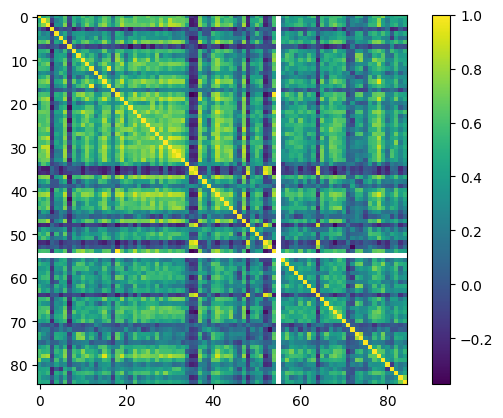

In [26]:

# Calculate the covariance matrix using pandas
corr_matrix = daily_returns.corr()

plt.imshow(corr_matrix, cmap='viridis')
plt.colorbar()  # Add a colorbar to show the scale

plt.show()